In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
from sklearn.metrics import mean_absolute_error

C:\Anaconda\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Load Data

In [2]:
os.chdir('../../Data/Preprocessed/')
data = {}
locations = ['centar', 'gazibaba', 'karpos', 'kicevo', 'kumanovo', 'lisice', 'miladinovci', 'tetovo']
for loc in locations:
    data[loc] = pd.read_csv(loc + '.csv')
    data[loc]['time'] = pd.to_datetime(data[loc]['time'], infer_datetime_format=True)
    data[loc].set_index('time', inplace = True)
    data[loc]['PM10'] = np.expm1(data[loc]['PM10'])

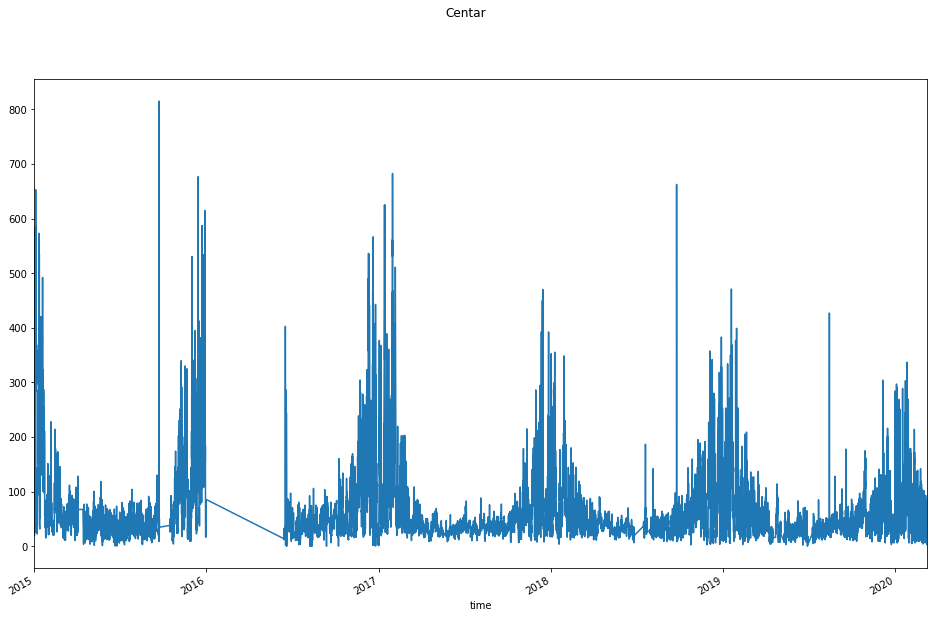

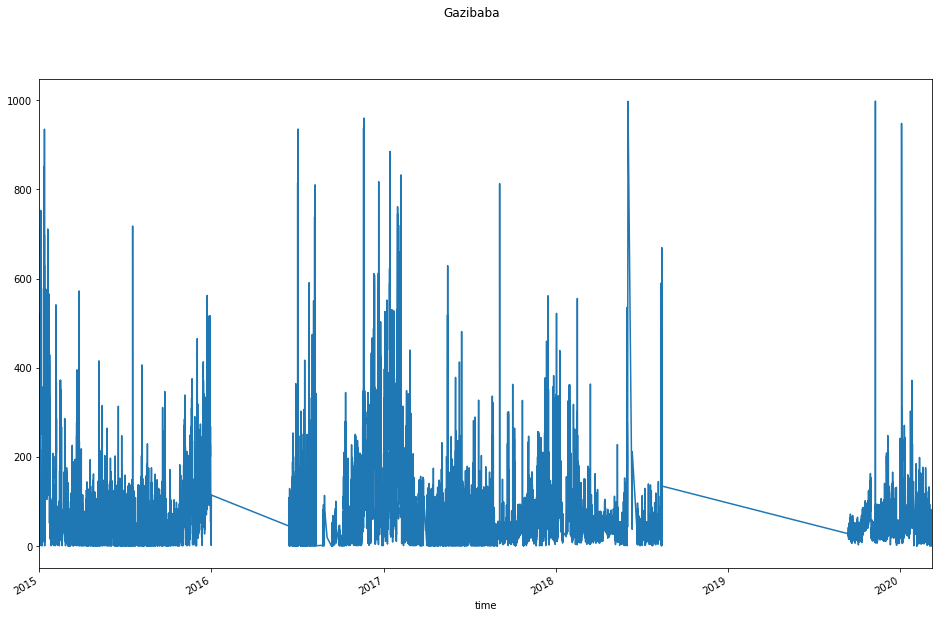

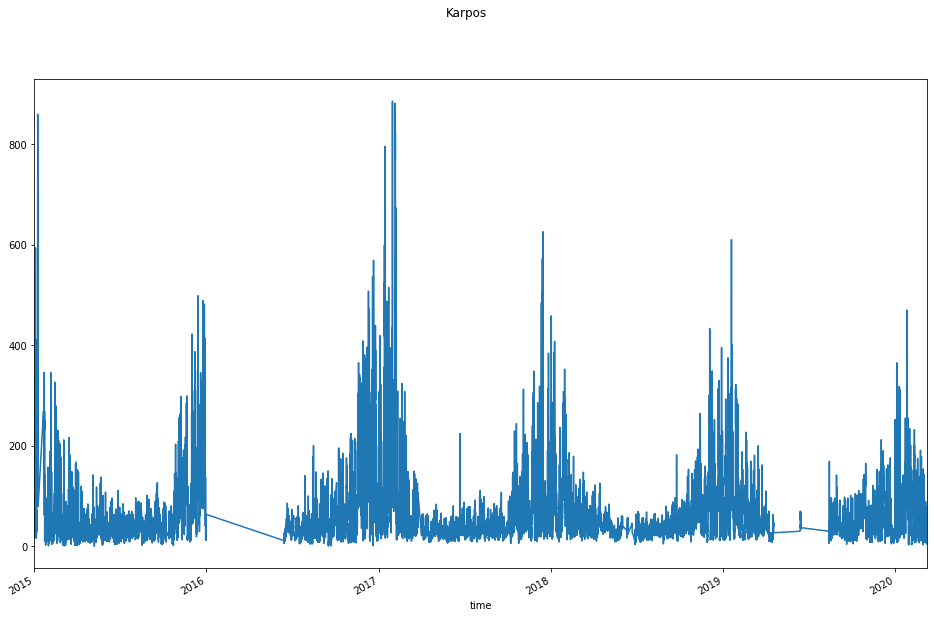

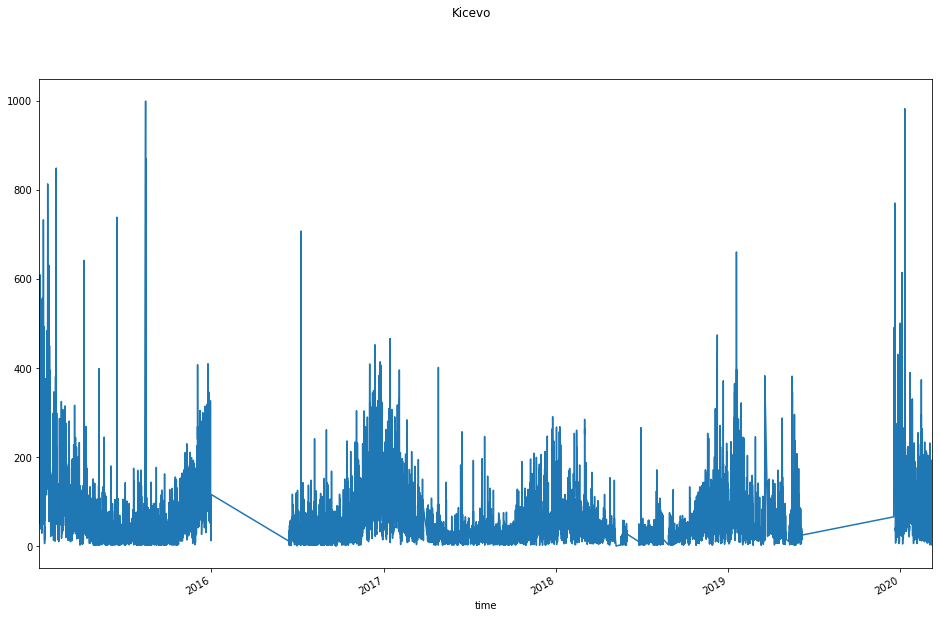

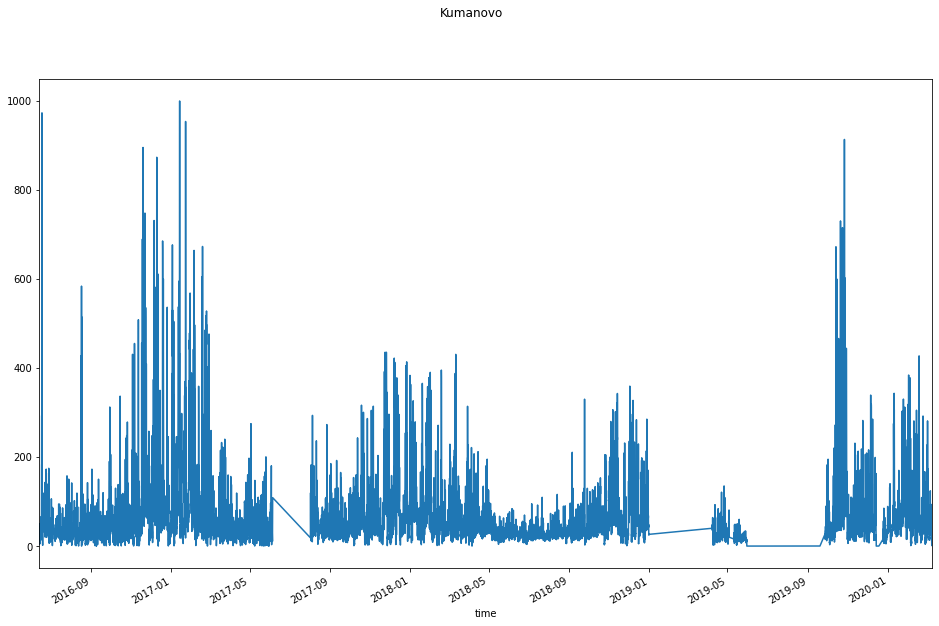

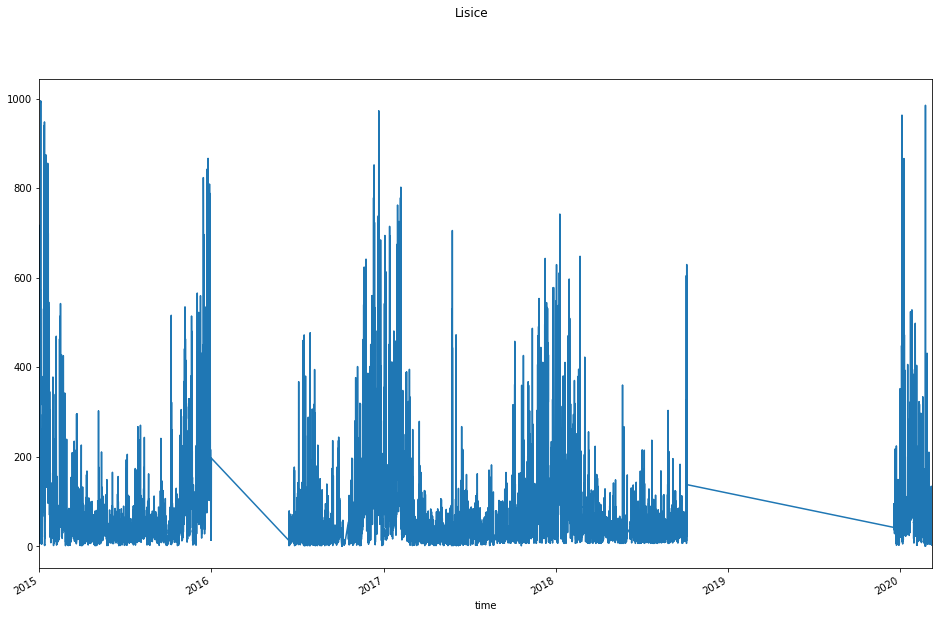

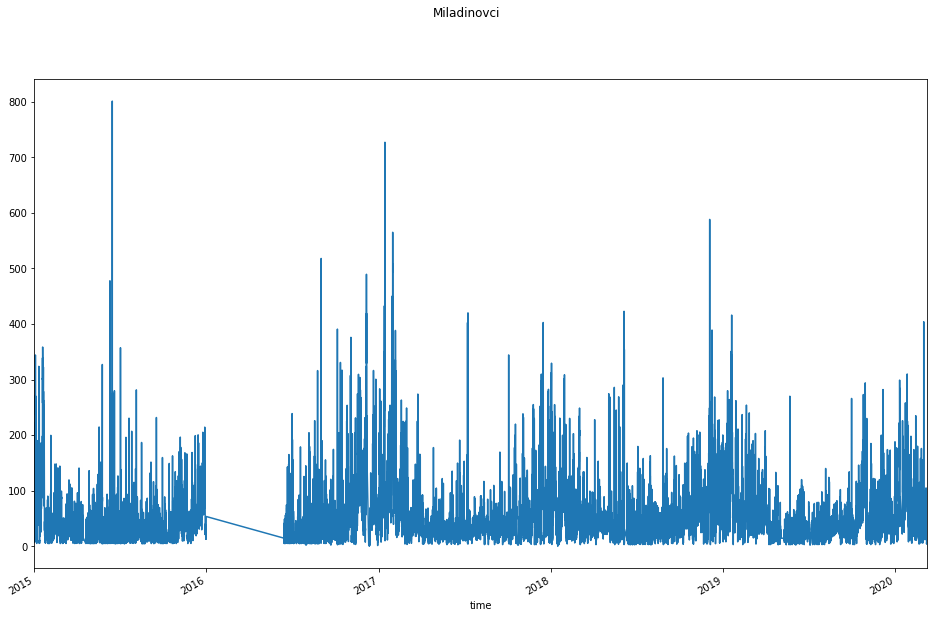

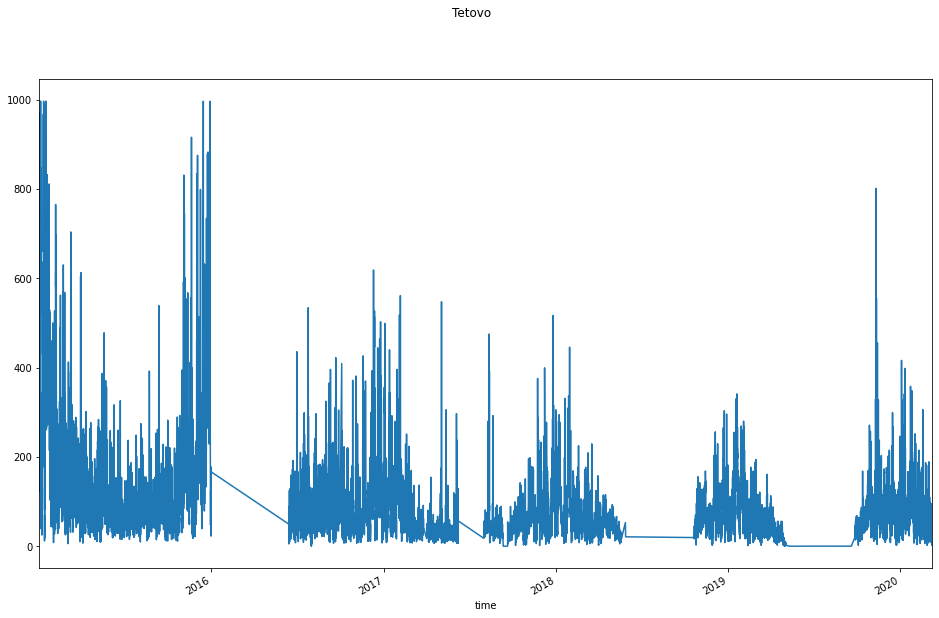

In [3]:
for loc in locations:
    fig = plt.figure(figsize=(16,10))
    fig.suptitle(loc.capitalize())
    data[loc].loc[:,'PM10'].plot()


We take the data from 2017 onward

In [4]:
for loc in locations:
    data[loc] = data[loc].loc['2018-01-01':]

## Facebook Prophet

In [5]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import add_changepoints_to_plot


In [6]:
df_prophet = {}
df_prophet_train = {}
df_prophet_test = {}
for loc in locations:
    df_prophet[loc] = data[loc].reset_index().loc[:,['time','PM10']]
    df_prophet[loc].rename({'time':'ds','PM10':'y'}, axis = 1, inplace = True)
    df_prophet_train[loc] = df_prophet[loc][df_prophet[loc]['ds']<'2020-01-01']
    df_prophet_test[loc] = df_prophet[loc][df_prophet[loc]['ds']>='2020-01-01']

In [7]:
forecast_prophet = {}
future = {}
for loc in ['centar']:
    m = Prophet(changepoint_prior_scale=0.13, yearly_seasonality=True)
    m.fit(df_prophet_train[loc].loc[:,['ds','y']])
    forecast_prophet[loc] = m.predict(df_prophet_test[loc].loc[:,['ds','y']])
    future[loc] = m.make_future_dataframe(periods=300, freq='H', include_history=True)
    #forecast_prophet[loc] = m.predict(future[loc])


with open('C:/Users/David Galevski/IdeaProjects/DataMiningProject/Notebooks/ARIMA/arima_prophet.pickle', 'wb') as handle:
    pickle.dump(forecast_prophet, handle)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


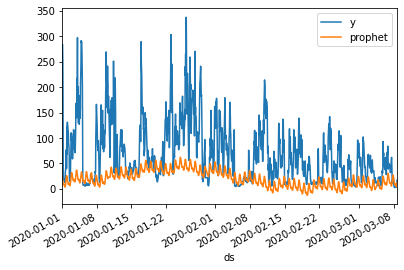

In [8]:
for loc in ['centar']:
    df_prophet_test[loc]['prophet'] = forecast_prophet[loc].yhat.values
    display(df_prophet_test[loc].loc[:,['y', 'prophet']].set_index(df_prophet_test[loc].ds).plot())

In [9]:
mean_absolute_error(df_prophet_test['centar'].y, df_prophet_test['centar'].prophet)

52.19885543170031

<Figure size 1152x720 with 0 Axes>

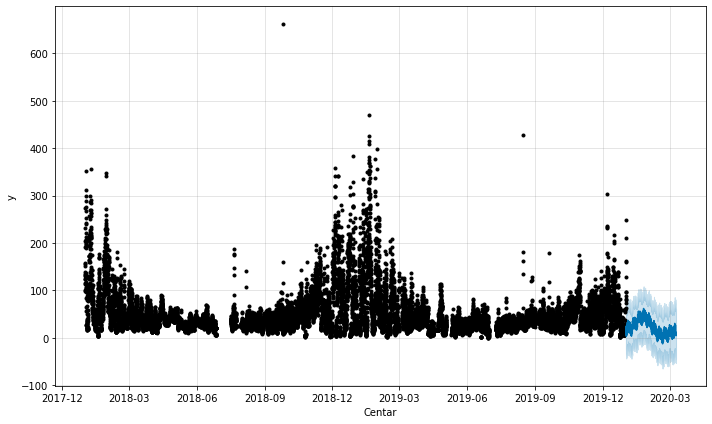

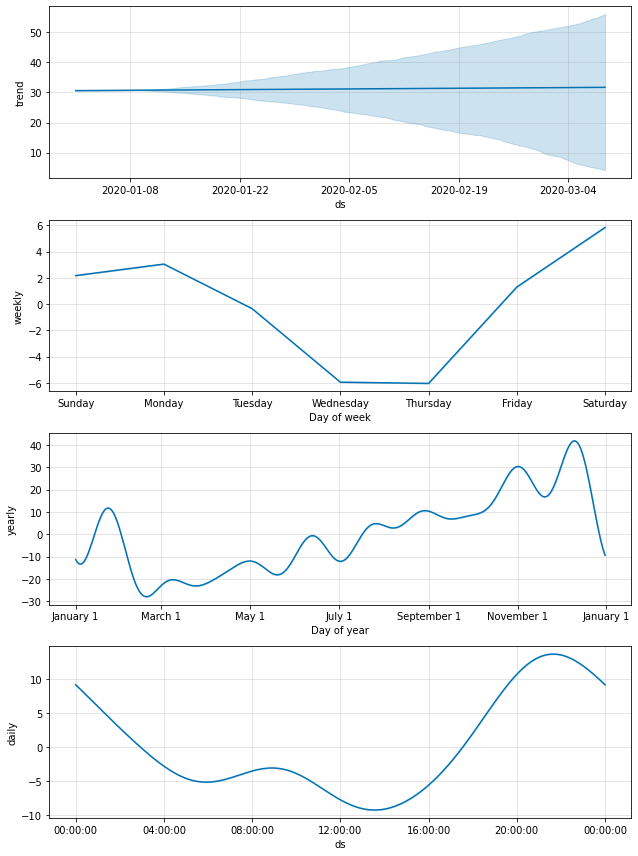

In [10]:
for loc in ['centar']:
    fig = plt.figure(figsize=(16,10))
    fig.suptitle(loc.capitalize())
    m.plot(forecast_prophet[loc],  xlabel=loc.capitalize(), )
    m.plot_components(forecast_prophet[loc])



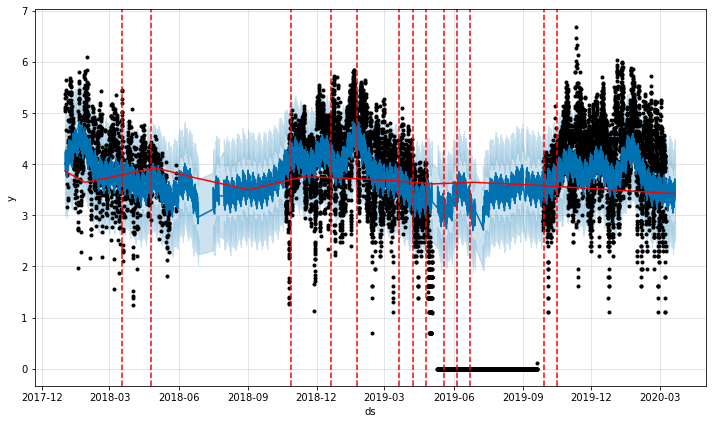

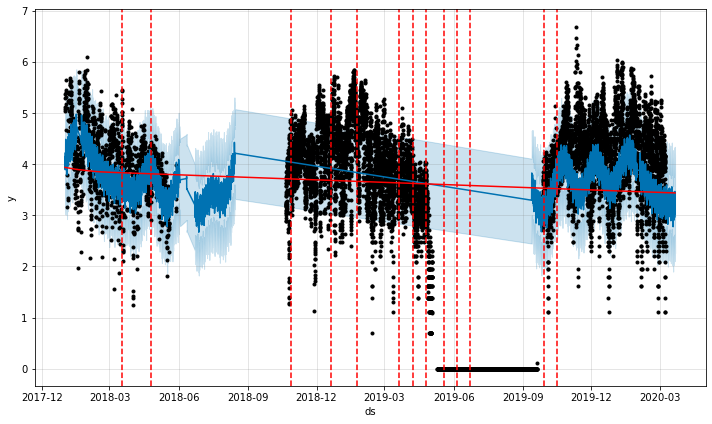

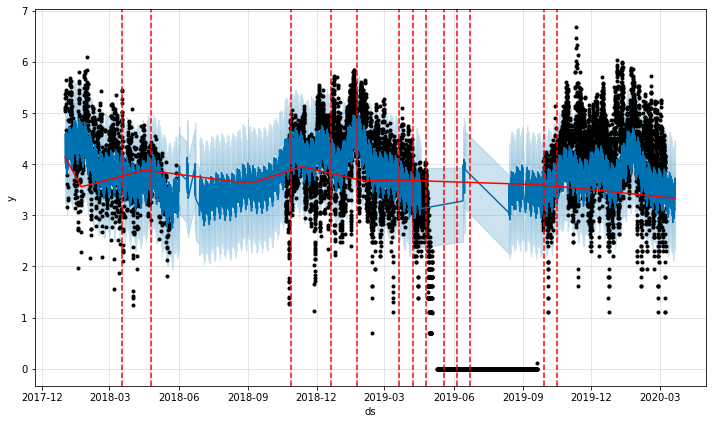

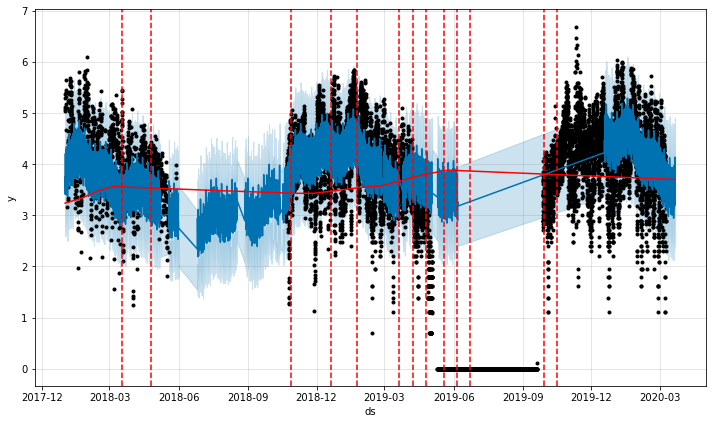

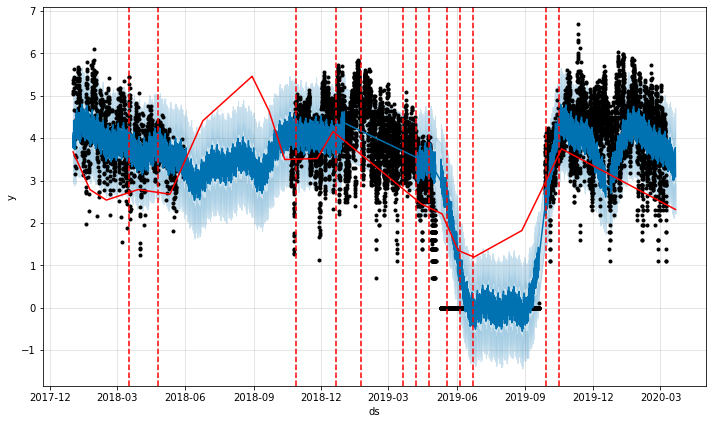

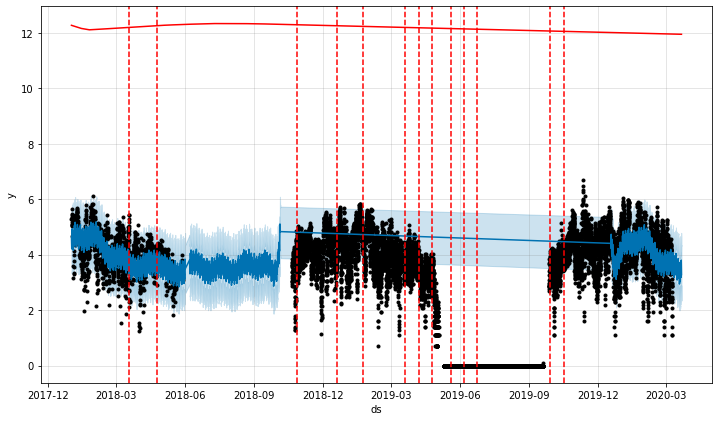

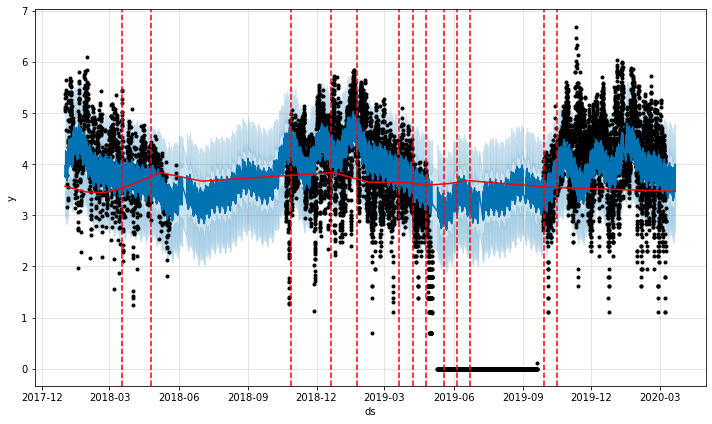

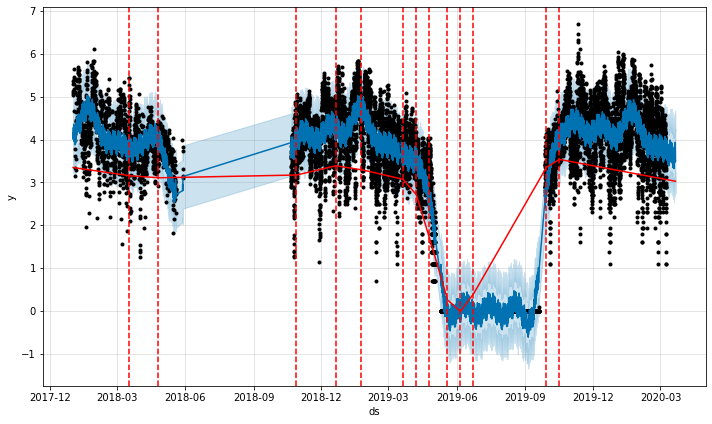

In [10]:
for loc in locations:
    fig = m.plot(forecast_prophet[loc])
    a = add_changepoints_to_plot(fig.gca(), m, forecast_prophet[loc])

## AutoArima

Splitting data into train and test set

In [23]:
extra_features = ['O3', 'PM25', 'cloudCover', 'dewPoint', 'humidity',
                        'pressure', 'temperature', 'uvIndex', 'visibility', 'windBearing',
                        'windSpeed', 'no precip', 'rain', 'sleet', 'snow', 'Clear', 'Drizzle',
                        'Foggy', 'Light Rain', 'Mostly Cloudy', 'Overcast', 'Partly Cloudy',
                        'Possible Drizzle', 'Possible Flurries', 'Possible Light Rain',
                        'Possible Light Sleet', 'Possible Light Snow', 'Rain', 'Snow', 'Windy',
                        'Windy and Mostly Cloudy', 'Windy and Overcast',
                        'Windy and Partly Cloudy', 'AQI_PM25', 'AQI_PM10', 'AQI_O3',
                        'PM10_history', 'month', 'week_no']

In [24]:
forecast = {}
for loc in locations:
    train = data[loc][data[loc]['time.1']<'2020-01-01']
    test = data[loc][data[loc]['time.1']>='2020-01-01']


    model = auto_arima(train.PM10, trace=True, error_action='ignore', suppress_warnings=True)
    forecast[loc] = model.predict(n_periods=test.shape[0])

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-5814.812, BIC=-5768.741, Fit time=19.422 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-5217.229, BIC=-5201.872, Fit time=2.002 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-5339.081, BIC=-5316.045, Fit time=1.067 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-5353.667, BIC=-5330.631, Fit time=2.149 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-5822.861, BIC=-5784.468, Fit time=14.869 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-5371.742, BIC=-5341.028, Fit time=6.935 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=-5870.057, BIC=-5823.985, Fit time=27.541 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-5386.487, BIC=-5355.773, Fit time=2.951 seconds
Fit ARIMA: order=(2, 1, 4) seasonal_order=(0, 0, 0, 1); AIC=-5367.005, BIC=-5305.576, Fit time=24.198 seconds
Fit ARIMA: orde

In [25]:
with open('C:/Users/David Galevski/IdeaProjects/DataMiningProject/Notebooks/ARIMA/arima_model.pickle', 'wb') as handle:
    pickle.dump(forecast, handle)

In [26]:
with open('C:/Users/David Galevski/IdeaProjects/DataMiningProject/Notebooks/ARIMA/arima_model.pickle', 'rb') as handle:
    forecast2 = pickle.load(handle)


In [27]:

test_centar = data['centar'][data['centar']['time.1']>='2020-01-01']
test_centar['forecast_arima'] = forecast['centar']

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
test_centar.forecast_arima


time
2020-01-01 00:00:00    5.404309
2020-01-01 01:00:00    5.262865
2020-01-01 02:00:00    5.133047
2020-01-01 03:00:00    5.012848
2020-01-01 04:00:00    4.901556
                         ...   
2020-03-08 13:00:00    3.397319
2020-03-08 14:00:00    3.397247
2020-03-08 15:00:00    3.397174
2020-03-08 16:00:00    3.397102
2020-03-08 17:00:00    3.397030
Name: forecast_arima, Length: 1603, dtype: float64

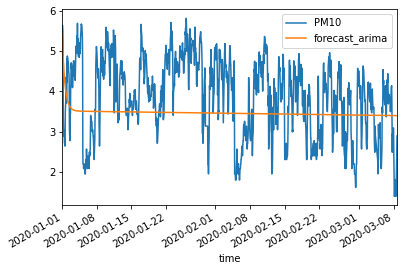

In [30]:

test_centar.loc[:,['PM10','forecast_arima']].plot()
